In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [4]:
#dataset load
drebin_all = pd.read_csv('drebin-215-dataset-5560malware-9476-benign.csv', 
                         usecols= [*range(0, 6),*range(7, 13),*range(14,19)
                                  ,21,23,24,*range(28,38),41,43,46,48,51,54,
                                   57,58,59,62,64,68,70,78,80,*range(83,87),
                                   *range(92, 95),98,101,102,104,109,123,128,
                                   140,142,145,147,148,152,155,156,158,167,
                                   171,172,180,190,215])

/home/galib/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
drebin_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Data columns (total 74 columns):
transact                                       15036 non-null int64
onServiceConnected                             15036 non-null int64
bindService                                    15036 non-null int64
attachInterface                                15036 non-null int64
ServiceConnection                              15036 non-null int64
android.os.Binder                              15036 non-null int64
Ljava.lang.Class.getCanonicalName              15036 non-null int64
Ljava.lang.Class.getMethods                    15036 non-null int64
Ljava.lang.Class.cast                          15036 non-null int64
Ljava.net.URLDecoder                           15036 non-null int64
android.content.pm.Signature                   15036 non-null int64
android.telephony.SmsManager                   15036 non-null int64
getBinder                                      15036 non-null int64
ClassLo

In [6]:
X = drebin_all.iloc[0:,0:73]  #independent columns
y = drebin_all.iloc[0:,-1]
X["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [7]:
y.dtypes

dtype('O')

In [8]:
y = y.map(dict(S=1, B=0))

In [9]:
y

0        1
1        1
2        1
3        1
4        1
        ..
15031    0
15032    0
15033    0
15034    0
15035    0
Name: class, Length: 15036, dtype: int64

## Variance 

In [23]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selector.fit_transform(X)

selector.variances_

array([0.2445894 , 0.24714789, 0.24671338, 0.2424672 , 0.24696753,
       0.24982834, 0.22137341, 0.20264542, 0.21487492, 0.24163741,
       0.22930581, 0.15091489, 0.15299733, 0.24957493, 0.24998804,
       0.24681176, 0.24457961, 0.24947353, 0.10684477, 0.24529832,
       0.2210801 , 0.24926008, 0.18636427, 0.16225229, 0.24895096,
       0.24841825, 0.24385159, 0.23195163, 0.0989895 , 0.2458468 ,
       0.04233176, 0.16870902, 0.24626435, 0.19811324, 0.23549318,
       0.16537612, 0.16935246, 0.16939023, 0.02025588, 0.04553195,
       0.09976385, 0.24847591, 0.03794453, 0.18157997, 0.02683864,
       0.02507577, 0.11198152, 0.01923465, 0.07158984, 0.13964136,
       0.01763445, 0.0287823 , 0.01949017, 0.24529832, 0.04342141,
       0.04936321, 0.22820076, 0.0350559 , 0.21394649, 0.24962801,
       0.0039745 , 0.00883252, 0.02469711, 0.00535805, 0.17669433,
       0.21524786, 0.00271935, 0.00252088, 0.08019199, 0.23680771,
       0.01195777, 0.08718915, 0.00099661])

In [18]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


## SelectKBest (Chi)

In [19]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [20]:
featureScores

,APIs,Score
0,transact,2235.423721
1,onServiceConnected,2099.078102
2,bindService,2103.736162
3,attachInterface,2134.145591
4,ServiceConnection,2086.729283
...,...,...
68,ProcessBuilder,19.553048
69,Ljava.lang.Class.getResource,20.082388
70,defineClass,19.715080
71,findClass,19.175419


In [21]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                                 APIs        Score
0                            transact  2235.423721
3                     attachInterface  2134.145591
2                         bindService  2103.736162
1                  onServiceConnected  2099.078102
4                   ServiceConnection  2086.729283
5                   android.os.Binder  1886.582489
11       android.telephony.SmsManager  1846.663059
6   Ljava.lang.Class.getCanonicalName  1761.841453
7         Ljava.lang.Class.getMethods  1639.594097
8               Ljava.lang.Class.cast  1612.640324


## Feature Importances

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

model = ExtraTreesClassifier(random_state=2)
#model_rf = RandomForestClassifier()
model.fit(X_train,y_train)
#model_rf.fit(X_train,y_train)

/home/galib/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=2, verbose=0,
                     warm_start=False)

In [15]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[1.01935696e-01 3.68072952e-02 1.96180578e-02 3.42520868e-02
 3.51450756e-02 5.91543981e-02 1.00252110e-02 6.65214819e-03
 8.19314701e-03 1.23648890e-02 4.98638104e-03 7.94639535e-02
 1.56852832e-02 2.22073033e-02 4.22202099e-02 9.72965070e-03
 1.10101903e-02 4.68948341e-03 9.77832060e-04 3.52889692e-03
 2.40883037e-02 5.13099617e-03 6.69733145e-02 1.76897143e-03
 9.03227223e-03 3.55368299e-03 1.99234531e-02 7.53087778e-03
 8.21778007e-03 4.17364387e-03 2.49259944e-02 2.45795424e-02
 1.13952945e-02 1.02551362e-02 6.38232760e-03 2.68895432e-03
 4.94615630e-03 4.90131484e-03 7.83077434e-03 2.55033569e-03
 2.18506427e-02 4.41204132e-02 5.96358336e-04 7.41785186e-03
 6.54850528e-04 2.43076761e-04 7.66155473e-03 1.79464545e-03
 3.55763797e-03 7.07894527e-03 1.45572207e-03 5.06927895e-03
 3.75998252e-03 7.10628257e-03 1.09812764e-03 2.10040963e-03
 1.45988002e-02 3.02901417e-03 1.22577934e-02 2.04143134e-02
 5.24331053e-05 1.37576961e-03 1.10690550e-02 2.99192702e-04
 9.34699053e-03 1.090473

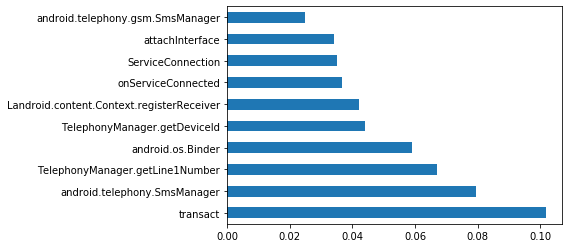

In [16]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
sorted_features = pd.Series(feat_importances.sort_values(ascending = False))
sorted_features.index[72]

'Runtime.loadLibrary'

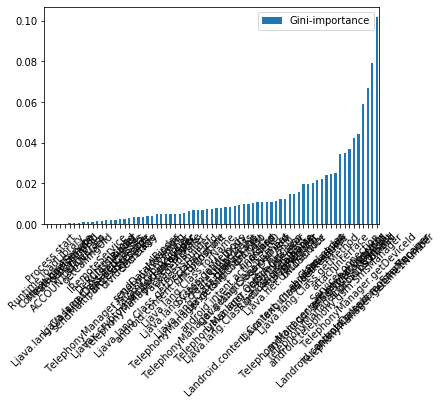

In [18]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

In [53]:
top_30_apis = feat_importances.nlargest(30).index
top_30_apis

Index(['transact', 'android.telephony.SmsManager',
       'TelephonyManager.getLine1Number', 'android.os.Binder',
       'TelephonyManager.getDeviceId',
       'Landroid.content.Context.registerReceiver', 'onServiceConnected',
       'ServiceConnection', 'attachInterface',
       'android.telephony.gsm.SmsManager', 'TelephonyManager.getSubscriberId',
       'android.content.pm.PackageInfo', 'ClassLoader', 'abortBroadcast',
       'TelephonyManager.getNetworkOperator', 'Ljava.lang.Class.getMethod',
       'bindService', 'getBinder', 'Ljava.lang.Class.getResource',
       'HttpUriRequest', 'Ljava.net.URLDecoder', 'Runtime.exec',
       'Runtime.getRuntime', 'SET_ALARM',
       'Landroid.content.Context.unregisterReceiver', 'onBind', 'findClass',
       'Ljava.lang.Object.getClass', 'Ljava.lang.Class.getCanonicalName',
       'Ljava.lang.Class.getField'],
      dtype='object')

In [54]:
top_thirty_api_index = []
print('Variance of APIs:\n')
for api in top_30_apis:
    top_thirty_api_index.append(X_train.columns.get_loc(api))
    #print(X.loc[0:,api].var())
    
top_thirty_api_index

Variance of APIs:



[0,
 11,
 22,
 5,
 41,
 14,
 1,
 4,
 3,
 30,
 31,
 20,
 13,
 40,
 59,
 26,
 2,
 12,
 69,
 56,
 9,
 58,
 32,
 62,
 16,
 65,
 71,
 33,
 6,
 15]

## Feature Selection Based on Correlation

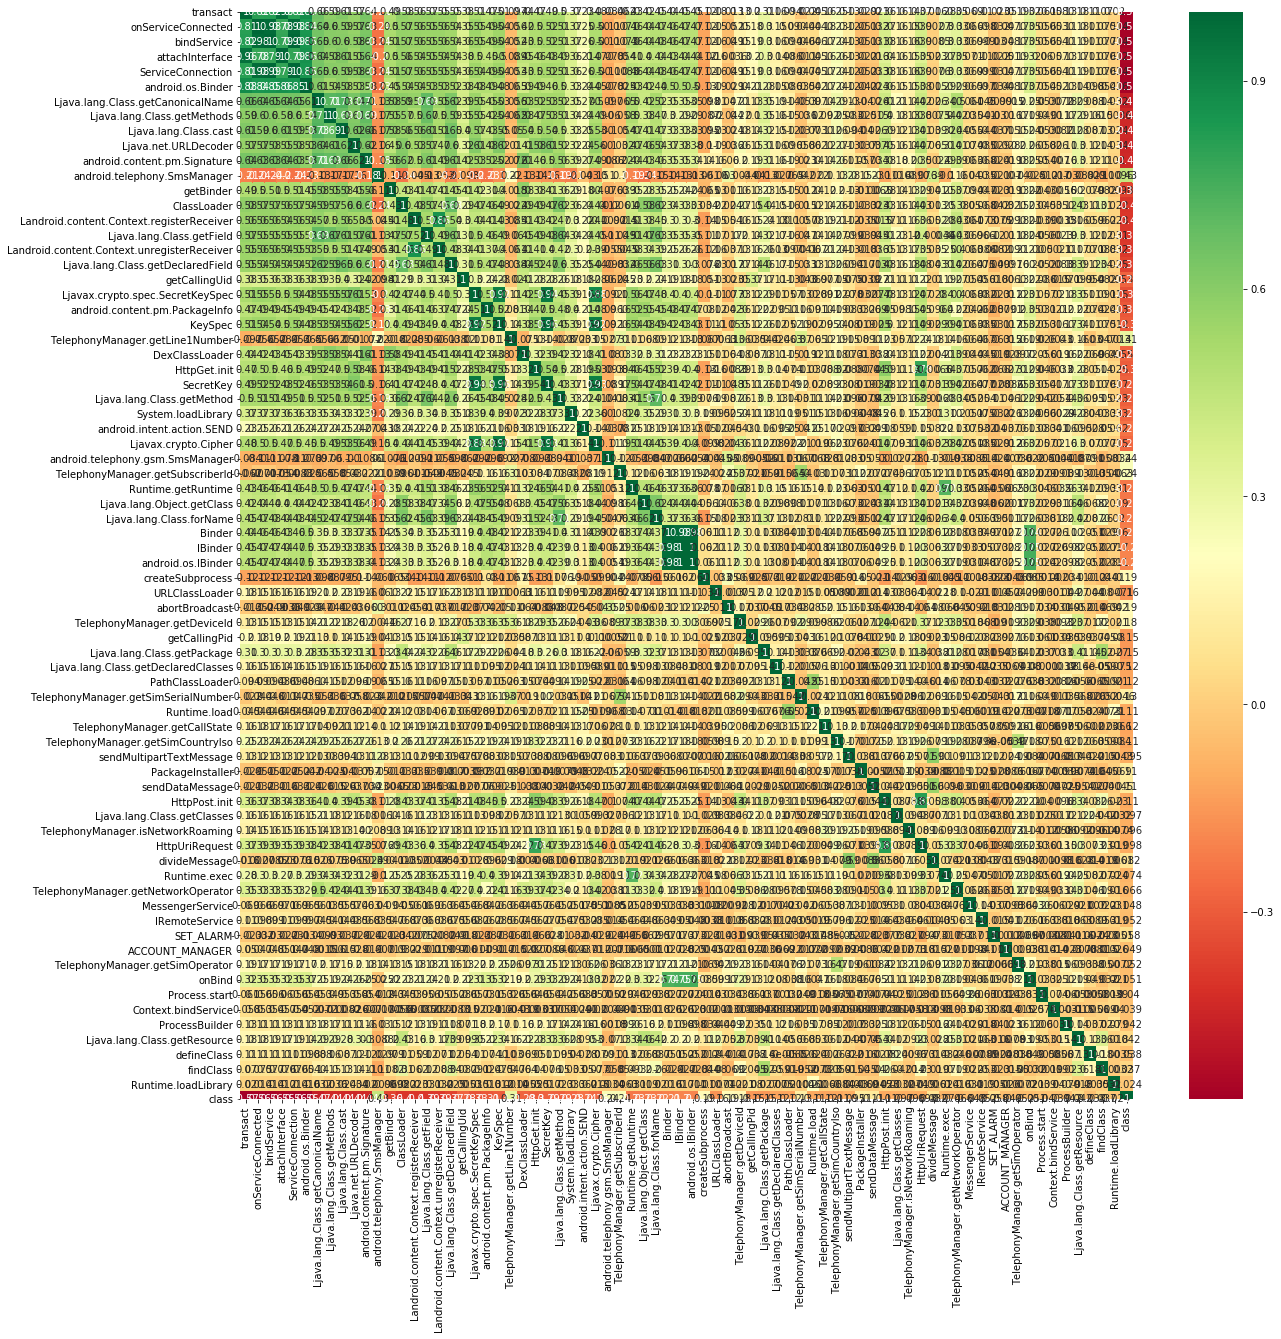

In [10]:
import seaborn as sns
#get correlations of each features in dataset
drebin_all_processed = pd.concat([X,y], axis = 1) #concatenate column
corrmat = drebin_all_processed.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(drebin_all_processed[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
cor_target = abs(corrmat["class"])
cor_target
high_correlated_features = cor_target[cor_target<0.05]
high_correlated_features


MessengerService                0.048484
ACCOUNT_MANAGER                 0.048845
Process.start                   0.040054
Context.bindService             0.038557
ProcessBuilder                  0.041765
Ljava.lang.Class.getResource    0.041789
defineClass                     0.038174
findClass                       0.036603
Runtime.loadLibrary             0.024206
Name: class, dtype: float64

In [13]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

In [22]:
corr_features = get_correlation(X, 0.8)
corr_features

{'HttpUriRequest',
 'IBinder',
 'KeySpec',
 'Landroid.content.Context.unregisterReceiver',
 'Ljavax.crypto.Cipher',
 'SecretKey',
 'ServiceConnection',
 'android.os.Binder',
 'android.os.IBinder',
 'attachInterface',
 'bindService',
 'onServiceConnected'}

In [25]:
X_train_uncorrelated = X_train.drop(labels = corr_features, axis =1)
X_test_uncorrelated = X_test.drop(labels = corr_features, axis =1)


In [1]:
corrdata = corrmat.abs().stack()
corrdata = corrdata.sort_values(ascending=False)
corrdata = corrdata[corrdata>0.85]
corrdata = corrdata[corrdata<1]
corrdata

NameError: name 'corrmat' is not defined

In [46]:
corrdata = pd.DataFrame(corrdata).reset_index()
corrdata.columns = ['features1', 'features2', 'corr_value']
#corrdata

In [47]:
grouped_feature_list = []
correlated_groups_list = []
for feature in corrdata.features1.unique():
    if feature not in grouped_feature_list:
        correlated_block = corrdata[corrdata.features1 == feature]
        grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
        correlated_groups_list.append(correlated_block)

In [48]:
len(correlated_groups_list)

5

In [49]:
#Feature Importance based on tree based classifiers 

important_features = []
for group in correlated_groups_list:
    features = list(group.features1.unique()) + list(group.features2.unique())
    rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
    rf.fit(X_train[features], y_train)
    
    importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
    importance.columns = ['features', 'importance']
    importance.sort_values(by = 'importance', ascending = False, inplace = True)
    feat = importance.iloc[0]
    important_features.append(feat)

In [50]:
important_features= pd.DataFrame(important_features)
important_features.reset_index(inplace=True, drop = True)
important_features

,features,importance
0,IBinder,0.376179
1,ServiceConnection,0.422765
2,attachInterface,0.396570
3,Ljavax.crypto.spec.SecretKeySpec,0.496869
4,Landroid.content.Context.registerReceiver,0.525250


In [51]:
features_to_consider = set(important_features['features'])
features_to_discard = set(corr_features) - set(features_to_consider)
features_to_discard = list(features_to_discard)
X_train_grouped_correlated = X_train.drop(labels = features_to_discard, axis = 1)
X_test_grouped_correlated = X_test.drop(labels = features_to_discard, axis = 1)

In [119]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col
def grouped_correlated(X):
    corr_features = get_correlation(X, 0.85)
    X_uncorrelated = X.drop(labels = corr_features, axis =1)
    corrmat = X.corr()
    corrdata = corrmat.abs().stack()
    corrdata = corrdata.sort_values(ascending=False)
    corrdata = corrdata[corrdata>0.85]
    corrdata = corrdata[corrdata<1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['features1', 'features2', 'corr_value']
    #corrdata
    grouped_feature_list = []
    correlated_groups_list = []
    for feature in corrdata.features1.unique():
        if feature not in grouped_feature_list:
            correlated_block = corrdata[corrdata.features1 == feature]
            grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
            correlated_groups_list.append(correlated_block)
    #Feature Importance based on tree based classifiers 

    important_features = []
    for group in correlated_groups_list:
        features = list(group.features1.unique()) + list(group.features2.unique())
        rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
        rf.fit(X[features], y_train)

        importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
        importance.columns = ['features', 'importance']
        importance.sort_values(by = 'importance', ascending = False, inplace = True)
        feat = importance.iloc[0]
        important_features.append(feat)
    important_features= pd.DataFrame(important_features)
    important_features.reset_index(inplace=True, drop = True)
    important_features
    features_to_consider = set(important_features['features'])
    features_to_discard = set(corr_features) - set(features_to_consider)
    features_to_discard = list(features_to_discard)
    X_grouped_correlated = X.drop(labels = features_to_discard, axis = 1)
    print (X_grouped_correlated.shape)
    return X_grouped_correlated
def to_dataframe(X):
    print(X.shape)
    X_return = pd.DataFrame(data=X,
          index=np.arange(1, X.shape[0]+1), columns=np.arange(1, X.shape[1]+1))
    
    return X_return

In [121]:
grouped_correlated(to_dataframe(X_train_mutual_info)).shape

(12028, 36)
(12028, 30)


(12028, 30)

## Feature Selection Based on Mutual Information (Entropy) Gain

In [46]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [47]:
mi = mutual_info_classif(X_train, y_train)
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


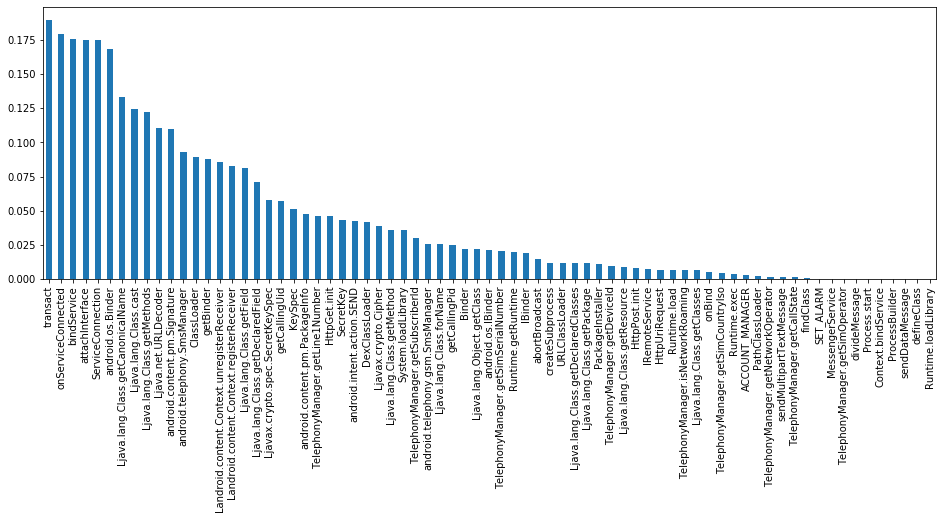

In [48]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))


In [49]:
sel = SelectPercentile(mutual_info_classif, percentile=50).fit(X_train, y_train)
X_train.columns[sel.get_support()]

Index(['transact', 'onServiceConnected', 'bindService', 'attachInterface',
       'ServiceConnection', 'android.os.Binder',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast', 'Ljava.net.URLDecoder',
       'android.content.pm.Signature', 'android.telephony.SmsManager',
       'getBinder', 'ClassLoader', 'Landroid.content.Context.registerReceiver',
       'Ljava.lang.Class.getField',
       'Landroid.content.Context.unregisterReceiver',
       'Ljava.lang.Class.getDeclaredField', 'getCallingUid',
       'Ljavax.crypto.spec.SecretKeySpec', 'android.content.pm.PackageInfo',
       'KeySpec', 'TelephonyManager.getLine1Number', 'DexClassLoader',
       'HttpGet.init', 'SecretKey', 'Ljava.lang.Class.getMethod',
       'System.loadLibrary', 'android.intent.action.SEND',
       'Ljavax.crypto.Cipher', 'android.telephony.gsm.SmsManager',
       'Runtime.getRuntime', 'Ljava.lang.Object.getClass',
       'Ljava.lang.Class.forName', 'Binder',

In [50]:
len(X_train.columns[sel.get_support()])

36

In [51]:
X_train_mutual_info = sel.transform(X_train)
X_test_mutual_info = sel.transform(X_test)
X_test_mutual_info.shape

(3008, 36)

## Feature Selection Based on Univariate ROC_AUC for Classification

In [62]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in X_train.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train[feature].to_frame(), y_train)
    y_pred = clf.predict(X_test[feature].to_frame())
    roc_auc.append(roc_auc_score(y_test, y_pred))

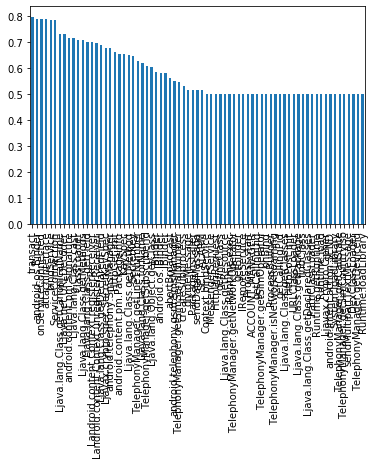

In [63]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train.columns
roc_values.sort_values(ascending =False, inplace = True)
roc_values.plot.bar()

In [64]:
sel = roc_values[roc_values>0.5]
X_train_roc = X_train[sel.index]
X_test_roc = X_test[sel.index]
X_test_roc.shape

(3008, 38)

## Feature Selection Based on Univariate (ANOVA) Test for Classification

In [67]:
from sklearn.feature_selection import f_classif

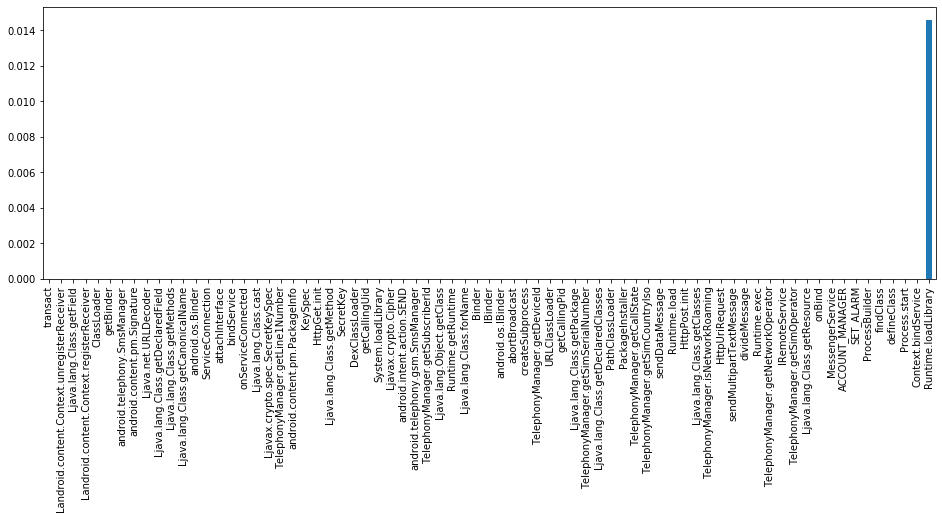

In [68]:
sel = f_classif(X_train, y_train)
#sel

p_values = pd.Series(sel[1])
p_values.index = X_train.columns
p_values.sort_values(ascending = True, inplace = True)
p_values.plot.bar(figsize = (16, 5))

In [69]:
p_values = p_values[p_values<0.01]
p_values.index.shape

(72,)

## Recursive Feature Elimination (RFE) by Using Tree Based and Gradient Based Estimators

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [29]:
#Feature selection by feature importance of random forest classifier
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1))
sel.fit(X, y)
sel.get_support()
features = X.columns[sel.get_support()]
len(features)

25

In [28]:
np.mean(sel.estimator_.feature_importances_)


0.0136986301369863

In [30]:
X_select_rf = sel.transform(X)
X_select_rf.shape

(15036, 25)

In [128]:
#Recursive Feature Elimination (RFE)¶

from sklearn.feature_selection import RFE
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = 30)
sel.fit(X_train, y_train)
features = X_train.columns[sel.get_support()]


In [129]:
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)
X_train_rfe.shape

(12028, 30)

In [90]:
#best RFE(RandomForestClassifier Parameter
clear_metrics()
for index in range(1, 31):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_train_rfe_optimal = sel.transform(X_train)
    X_test_rfe_optimal = sel.transform(X_test)
    print('Selected Feature: ', index)
    run_randomForest(X_train_rfe_optimal, X_test_rfe_optimal, y_train, y_test, index)
    print()

Selected Feature:  1
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9622    0.6423    0.7703      1940
           1     0.5949    0.9541    0.7328      1068

    accuracy                         0.7530      3008
   macro avg     0.7785    0.7982    0.7516      3008
weighted avg     0.8318    0.7530    0.7570      3008


Selected Feature:  2
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9317    0.6964    0.7971      1940
           1     0.6220    0.9073    0.7380      1068

    accuracy                         0.7713      3008
   macro avg     0.7768    0.8018    0.7675      3008
weighted avg     0.8217    0.7713    0.7761      3008


Selected Feature:  3
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9437    0.6918    0.7983      1940
           1     0.6230    0.9251    0.7445   

KeyboardInterrupt: 

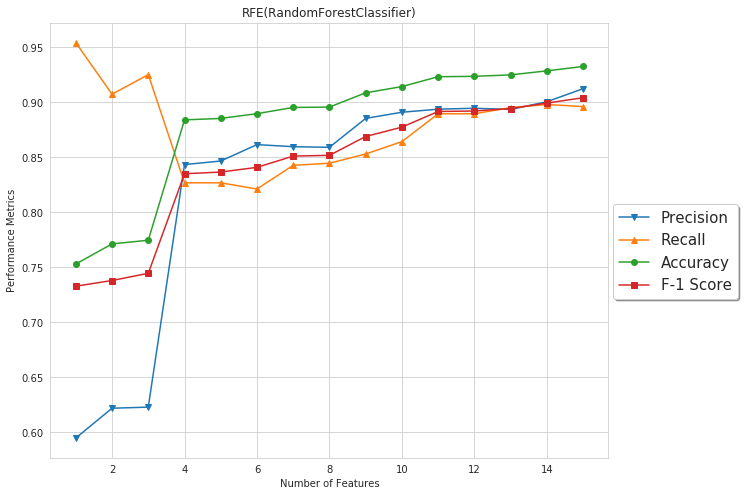

In [94]:
incremental_plot(1,16,"RFE(RandomForestClassifier)")

In [84]:
#Feature selection by GradientBoost Tree Importance
from sklearn.ensemble import GradientBoostingClassifier
sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = 30)
sel.fit(X_train, y_train)
features = X_train.columns[sel.get_support()]
len(features)

30

In [85]:
X_train_rfe_gradient = sel.transform(X_train)
X_test_rfe_gradient = sel.transform(X_test)
X_test_rfe_gradient.shape

(3008, 30)

## Optimal Parameter (RFE-Gradient Boosting Classifier)

In [96]:
#best REF Gradient BoostingClassifier Parameter
clear_metrics()
for index in range(1, 31):
    sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = index)
    sel.fit(X_train, y_train)
    X_train_rfe_gradient = sel.transform(X_train)
    X_test_rfe_gradient = sel.transform(X_test)
    print('Selected Feature: ', index)
    run_randomForest(X_train_rfe_gradient, X_test_rfe_gradient, y_train, y_test, index)
    print()

Selected Feature:  1
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9622    0.6423    0.7703      1940
           1     0.5949    0.9541    0.7328      1068

    accuracy                         0.7530      3008
   macro avg     0.7785    0.7982    0.7516      3008
weighted avg     0.8318    0.7530    0.7570      3008


Selected Feature:  2
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.8129    0.9206    0.8634      1940
           1     0.8101    0.6152    0.6993      1068

    accuracy                         0.8122      3008
   macro avg     0.8115    0.7679    0.7814      3008
weighted avg     0.8119    0.8122    0.8052      3008


Selected Feature:  3
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.8184    0.9082    0.8610      1940
           1     0.7918    0.6339    0.7041   

KeyboardInterrupt: 

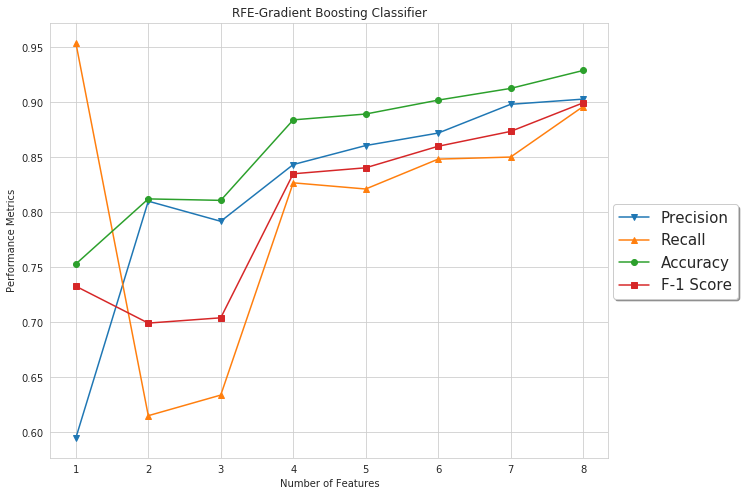

In [97]:
incremental_plot(1,9,"RFE-Gradient Boosting Classifier")

## Feature Selection Import

In [116]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

## SelectKBest

In [148]:
def generate_accuracy_and_heatmap(model, x, y):
#     cm = confusion_matrix(y,model.predict(x))
#     sns.heatmap(cm,annot=True,fmt="d")
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
    #print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                       #pd.Series(y,name='Actual')))
    return 1

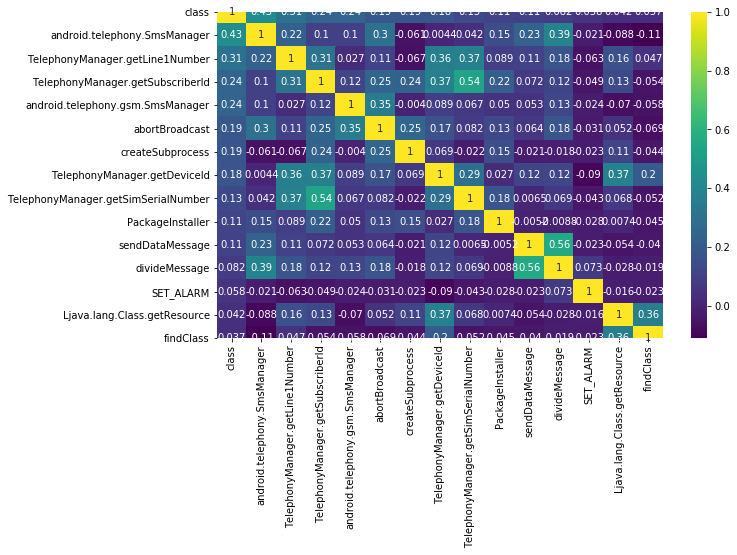

In [149]:
k = 15 #number of variables for heatmap
cols = drebin_all_processed.corr().nlargest(k, 'class')['class'].index
cm = drebin_all_processed[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)



In [459]:
clf_lr = RandomForestClassifier()      
lr_baseline_model = clf_lr.fit(X_train,y_train)

/home/galib/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [460]:
generate_accuracy_and_heatmap(lr_baseline_model, X_test, y_test)

Accuracy is:  0.9763962765957447
F1 score is:  0.9661743687470223




1

In [461]:
X_train.shape

(12028, 73)

In [462]:
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [463]:
selected_features_df = pd.DataFrame({'Feature':list(X_train.columns),
                                     'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

,Feature,Scores
0,transact,2235.423721
3,attachInterface,2134.145591
2,bindService,2103.736162
1,onServiceConnected,2099.078102
4,ServiceConnection,2086.729283
...,...,...
71,findClass,19.175419
66,Process.start,19.074310
67,Context.bindService,17.882166
65,onBind,9.715557


In [464]:
X_train_chi = select_feature.transform(X_train)
X_test_chi = select_feature.transform(X_test)


In [465]:
lr_chi_model = clf_lr.fit(X_train_chi,y_train)


In [466]:
generate_accuracy_and_heatmap(lr_chi_model, X_test_chi, y_test)

Accuracy is:  0.7716090425531915
F1 score is:  0.7376861397479955




1

In [467]:
rfe = RFE(estimator=clf_lr, step=1)
rfe = rfe.fit(X_train, y_train)

In [468]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
0,transact,1
24,HttpGet.init,1
27,System.loadLibrary,1
30,android.telephony.gsm.SmsManager,1
31,TelephonyManager.getSubscriberId,1
...,...,...
44,Ljava.lang.Class.getDeclaredClasses,34
67,Context.bindService,35
66,Process.start,36
60,MessengerService,37


In [469]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [470]:
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)
generate_accuracy_and_heatmap(lr_rfe_model, X_test_rfe, y_test)

Accuracy is:  0.9727393617021277
F1 score is:  0.960952380952381




1

In [471]:
rfecv = RFECV(estimator=clf_lr, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 49
Best features : Index(['transact', 'onServiceConnected', 'attachInterface',
       'ServiceConnection', 'android.os.Binder',
       'Ljava.lang.Class.getCanonicalName', 'Ljava.lang.Class.getMethods',
       'Ljava.lang.Class.cast', 'Ljava.net.URLDecoder',
       'android.content.pm.Signature', 'android.telephony.SmsManager',
       'ClassLoader', 'Landroid.content.Context.registerReceiver',
       'Ljava.lang.Class.getField',
       'Landroid.content.Context.unregisterReceiver',
       'Ljava.lang.Class.getDeclaredField', 'Ljavax.crypto.spec.SecretKeySpec',
       'android.content.pm.PackageInfo', 'TelephonyManager.getLine1Number',
       'HttpGet.init', 'SecretKey', 'Ljava.lang.Class.getMethod',
       'System.loadLibrary', 'android.intent.action.SEND',
       'Ljavax.crypto.Cipher', 'android.telephony.gsm.SmsManager',
       'TelephonyManager.getSubscriberId', 'Runtime.getRuntime',
       'Ljava.lang.Object.getClass', 'Ljava.lang.Class.forName', 'Binde

In [476]:
X_train.columns[rfecv.support_].shape

(49,)

In [477]:
rfecv.grid_scores_

array([0.75349359, 0.76712562, 0.81544142, 0.8759547 , 0.88393693,
       0.89599155, 0.90339169, 0.91012596, 0.91960493, 0.92658824,
       0.93465293, 0.9393082 , 0.94762269, 0.95128056, 0.95335898,
       0.95327595, 0.95784879, 0.96034311, 0.96100829, 0.96225565,
       0.96341948, 0.96491622, 0.96491577, 0.9674102 , 0.96749301,
       0.96799218, 0.96849072, 0.96740992, 0.96865708, 0.96948792,
       0.96932181, 0.97081883, 0.97090092, 0.97140036, 0.96998688,
       0.97156634, 0.97140026, 0.97331239, 0.97239856, 0.97273044,
       0.97273075, 0.97347871, 0.97189932, 0.97339586, 0.97281398,
       0.97356197, 0.97339562, 0.97372846, 0.97547455, 0.97273071,
       0.97356211, 0.9739778 , 0.97480903, 0.97480916, 0.97389458,
       0.97430982, 0.97322957, 0.97322895, 0.97406083, 0.97539118,
       0.97389461, 0.97406065, 0.97422725, 0.97414371, 0.97339537,
       0.97381124, 0.97489212, 0.97372791, 0.97455934, 0.97530792,
       0.97522441, 0.9733962 , 0.97514094])

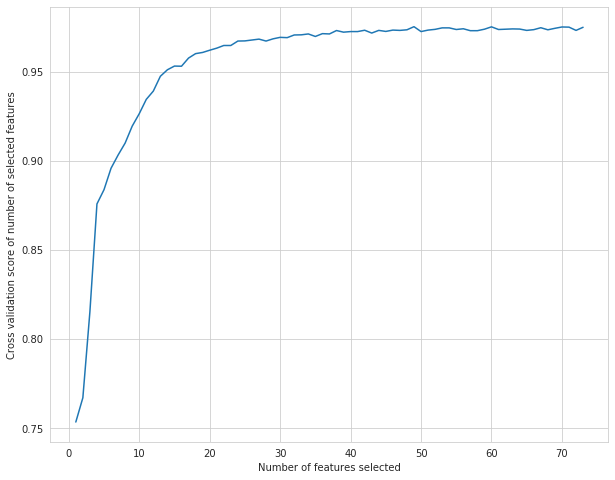

In [478]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [479]:
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

In [480]:
lr_rfecv_model = clf_lr.fit(X_train_rfecv, y_train)
generate_accuracy_and_heatmap(lr_rfecv_model, X_test_rfecv, y_test)

Accuracy is:  0.9757313829787234
F1 score is:  0.9654519640321817




1


## Feature Dimention Reduction by LDA

In [89]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [90]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)
X_lda.shape

(15036, 1)

## Feature Dimention Reduction by PCA

In [91]:
from sklearn.decomposition import PCA

In [561]:
pca = PCA(n_components=5, random_state=0)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape

(15036, 5)

## ML Model and compare performance: 

In [56]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [32]:
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [33]:
def allscore(scores,i):
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))

In [34]:
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

def run_randomForest(X,y, i=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=2,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i)

## Random Forest Classifiers for all APIs

In [42]:
X.shape

(15036, 73)

In [43]:
%%time
run_randomForest(X, y)


Classification Report for Random Forest:    0
Accuracy: 0.9763   (+/- 0.0015)
Precision: 0.9840   (+/- 0.0015)
Recall: 0.9513   (+/- 0.0015)
F-1 Score: 0.9674   (+/- 0.0015)
ROC-AUC: 0.9942   (+/- 0.0015)
CPU times: user 1.5 s, sys: 76.9 ms, total: 1.58 s
Wall time: 1.51 s


In [43]:
%%time
run_randomForest(X_train, y_train)


Classification Report for Random Forest:    0
Accuracy: 0.9736   (+/- 0.0012)
Precision: 0.9799   (+/- 0.0012)
Recall: 0.9490   (+/- 0.0012)
F-1 Score: 0.9642   (+/- 0.0012)
ROC-AUC: 0.9937   (+/- 0.0012)
CPU times: user 2.47 s, sys: 178 ms, total: 2.65 s
Wall time: 1.5 s


In [34]:
pre


[0.9798938826783529,
 0.9839994882760386,
 0.9839994882760386,
 0.9839994882760386,
 0.9861993482714151]

## Random Forest Classifiers for top 30 APIs

In [58]:
X_train_feature_imp_rf = X_train.iloc[0:, top_thirty_api_index]
X_test_feature_imp_rf = X_test.iloc[0:, top_thirty_api_index]
#X_train, X_test, y_train, y_test = train_test_split(X_top_ten, y, test_size = 0.2, random_state = 0)


In [59]:
%%time
run_randomForest(X_train_feature_imp_rf, y_train)



Classification Report for Random Forest:    0
Accuracy: 0.9663   (+/- 0.0012)
Precision: 0.9713   (+/- 0.0012)
Recall: 0.9377   (+/- 0.0012)
F-1 Score: 0.9541   (+/- 0.0012)
ROC-AUC: 0.9906   (+/- 0.0012)
CPU times: user 2.1 s, sys: 202 ms, total: 2.3 s
Wall time: 1.45 s


## Random Forest Classifiers without correlated Features

In [30]:
run_randomForest(X_train_uncorrelated, X_test_uncorrelated, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9761    0.9912    0.9836      1940
           1     0.9836    0.9560    0.9696      1068

    accuracy                         0.9787      3008
   macro avg     0.9799    0.9736    0.9766      3008
weighted avg     0.9788    0.9787    0.9787      3008

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.2 µs


## Random Forest Classifiers for Considering Correlated Features

In [52]:
run_randomForest(X_train_grouped_correlated, X_test_grouped_correlated, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9772    0.9928    0.9849      1940
           1     0.9865    0.9579    0.9720      1068

    accuracy                         0.9804      3008
   macro avg     0.9818    0.9753    0.9784      3008
weighted avg     0.9805    0.9804    0.9803      3008

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.4 µs


## Random Forest Classifiers for Mutual Information Gain Based Features

In [61]:
#50 % features
run_randomForest(X_train_mutual_info, X_test_mutual_info, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9645    0.9804    0.9724      1940
           1     0.9633    0.9345    0.9487      1068

    accuracy                         0.9641      3008
   macro avg     0.9639    0.9574    0.9605      3008
weighted avg     0.9641    0.9641    0.9640      3008

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.3 µs


## Random Forest Classifiers for ROC_AUC Based Features

In [65]:
#50 % features
run_randomForest(X_train_roc, X_test_roc, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9685    0.9830    0.9757      1940
           1     0.9682    0.9419    0.9549      1068

    accuracy                         0.9684      3008
   macro avg     0.9684    0.9625    0.9653      3008
weighted avg     0.9684    0.9684    0.9683      3008

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


## Random Forest Classifiers for random forest classifier Based Features

In [40]:
X_select_rf.shape


(15036, 25)

In [44]:
%%time 
run_randomForest(X_select_rf, y)



Classification Report for Random Forest:    0
Accuracy: 0.9603   (+/- 0.0031)
Precision: 0.9611   (+/- 0.0031)
Recall: 0.9304   (+/- 0.0031)
F-1 Score: 0.9455   (+/- 0.0031)
ROC-AUC: 0.9889   (+/- 0.0031)
CPU times: user 1.26 s, sys: 83.2 ms, total: 1.34 s
Wall time: 2.27 s


## Random Forest Classifiers for Recursive Feature Elimination (RFE)

In [81]:
#50 % features
run_randomForest(X_train_rfe, X_test_rfe, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9720    0.9845    0.9782      1940
           1     0.9712    0.9485    0.9597      1068

    accuracy                         0.9717      3008
   macro avg     0.9716    0.9665    0.9690      3008
weighted avg     0.9717    0.9717    0.9717      3008

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.7 µs


## Random Forest Classifiers for GradientBoost Tree Importance Based Features

In [86]:
#50 % features
run_randomForest(X_train_rfe_gradient, X_test_rfe_gradient, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9665    0.9830    0.9747      1940
           1     0.9681    0.9382    0.9529      1068

    accuracy                         0.9671      3008
   macro avg     0.9673    0.9606    0.9638      3008
weighted avg     0.9671    0.9671    0.9670      3008

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16.9 µs


## Random Forest Classifiers for LDA 

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size = 0.2, random_state = 0)


In [112]:
#50 % features
run_randomForest(X_train, X_test, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9737    0.9727    0.9732      1940
           1     0.9505    0.9522    0.9514      1068

    accuracy                         0.9654      3008
   macro avg     0.9621    0.9625    0.9623      3008
weighted avg     0.9654    0.9654    0.9654      3008

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


## Random Forest Classifiers for PCA

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.2, random_state = 0)


In [563]:
#50 % features
run_randomForest(X_train, X_test, y_train, y_test)
%time


Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9674    0.9794    0.9734      1940
           1     0.9617    0.9401    0.9508      1068

    accuracy                         0.9654      3008
   macro avg     0.9645    0.9597    0.9621      3008
weighted avg     0.9654    0.9654    0.9653      3008

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16 µs


## Optimal PCA calculation

In [416]:
clear_metrics()
for component in range(2,30):
    pca = PCA(n_components=component, random_state=0)
    pca.fit(X)
    X_pca_optimal = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca_optimal, y, test_size = 0.2, random_state = 0)
    print('Selected Components: ', component)
    run_randomForest(X_train, X_test, y_train, y_test,component)
    print()

Selected Components:  2
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9561    0.9660    0.9610      1940
           1     0.9370    0.9195    0.9282      1068

    accuracy                         0.9495      3008
   macro avg     0.9466    0.9427    0.9446      3008
weighted avg     0.9493    0.9495    0.9494      3008


Selected Components:  3
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9592    0.9691    0.9641      1940
           1     0.9427    0.9251    0.9338      1068

    accuracy                         0.9535      3008
   macro avg     0.9510    0.9471    0.9490      3008
weighted avg     0.9533    0.9535    0.9534      3008


Selected Components:  4
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9669    0.9794    0.9731      1940
           1     0.9616    0.9391    

Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9663    0.9912    0.9786      1940
           1     0.9833    0.9373    0.9597      1068

    accuracy                         0.9721      3008
   macro avg     0.9748    0.9643    0.9692      3008
weighted avg     0.9724    0.9721    0.9719      3008


Selected Components:  24
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9663    0.9897    0.9778      1940
           1     0.9804    0.9373    0.9584      1068

    accuracy                         0.9711      3008
   macro avg     0.9733    0.9635    0.9681      3008
weighted avg     0.9713    0.9711    0.9709      3008


Selected Components:  25
Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0     0.9687    0.9876    0.9781      1940
           1     0.9767    0.9419    0.9590      1068

    

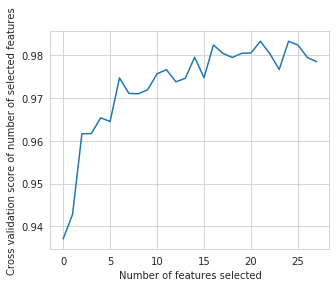

In [417]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(pre)

plt.show()

In [91]:
def incremental_plot(i,j,title): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)

    plt.title(title)
    plt.xlabel("Number of Features")
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, marker = 'v', mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2, marker = '^', mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3, marker = 'o', mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, marker = 's', mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)

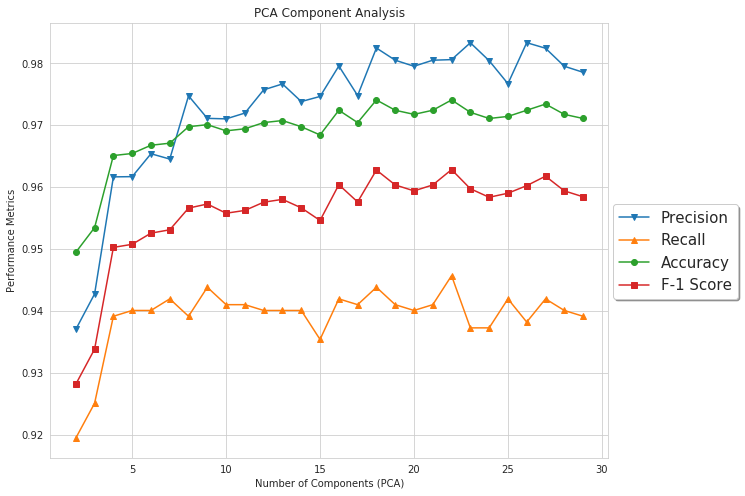

In [444]:
incremental_plot(2,30, "PCA Component Analysis")